# Interactive QA with DB

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2


In [ ]:
# | hide
from stringdale.core import get_git_root, load_env, checkLogs, json_render

load_env()

import pytest

Let us see a slightly more sophisticated version of the collecting user info workflow we saw in the decision diagram tutorial.

For this demo we will use a small utility for creating a shared in-memory [sqlite](https://www.sqlite.org/) db and connecting to it via [sqlalchemy](https://www.sqlalchemy.org/).

We will also use [SQLModel](https://sqlmodel.tiangolo.com/) to sync our database schema with the output schema we will request our LLM to parse from text.

In [ ]:
from pydantic import BaseModel,ConfigDict
from typing import Optional, Any
from sqlmodel import SQLModel, Session, select, Field

from stringdale import Define,V,E,Condition
from stringdale.chat import Chat
from stringdale.db import temp_sql_db

In [ ]:
engine = temp_sql_db()

Let us make our user data object

In [ ]:
#| hide
# used for restarting the db
SQLModel.metadata.clear()

In [ ]:
class User(SQLModel, table=True,extend_existing=True):
    id: int = Field(default=None, primary_key=True)
    name: Optional[str] = Field(default=None)
    age: Optional[int] = Field(default=None)
    email: Optional[str] = Field(default=None)

# Loads the schema of all SQLModel subclasses into the db
SQLModel.metadata.create_all(engine)

Let us recall our previous get user data workflow:

In [ ]:
ask_missing_data = Chat(
    model='gpt-4o-mini',
    messages=[
        {'role':'system','content':'''
        You are a helpful assistant asks the user for missing information.
        Do not ask for keys if they are not a part of the missing keys
        Ask the user for the following missing keys:
        {{missing_keys}}
        '''}])

format_new_info = Chat(
    model='gpt-4o-mini',
    messages=[
        {'role':'system','content':'''
        You are a helpful assistant that gets user data and makes sure it is complete.
        If you are not sure that you were given the relevant information, put None in the relevant field.
        Fill part of the missing keys based on the user data.
        If the user didnt provide info an a given missing key, leave it empty
        
        {% if current_info %}
        The information we have so far is:
        {{current_info}}
        {% endif %}
        The missing keys are:
        {{missing_keys}}
        '''},
        {'role':'user','content':'{{input}}'},
        
    ],
    output_schema=User)

class MissingKeys():
    def __init__(self,keys):
        self.keys = keys

    def get_missing_keys(self,obj):
        return [key for key in self.keys if getattr(obj,key,None) is None]

    def has_missing_keys(self,obj):
        return len(self.get_missing_keys(obj)) > 0

missing = MissingKeys(['name','age'])

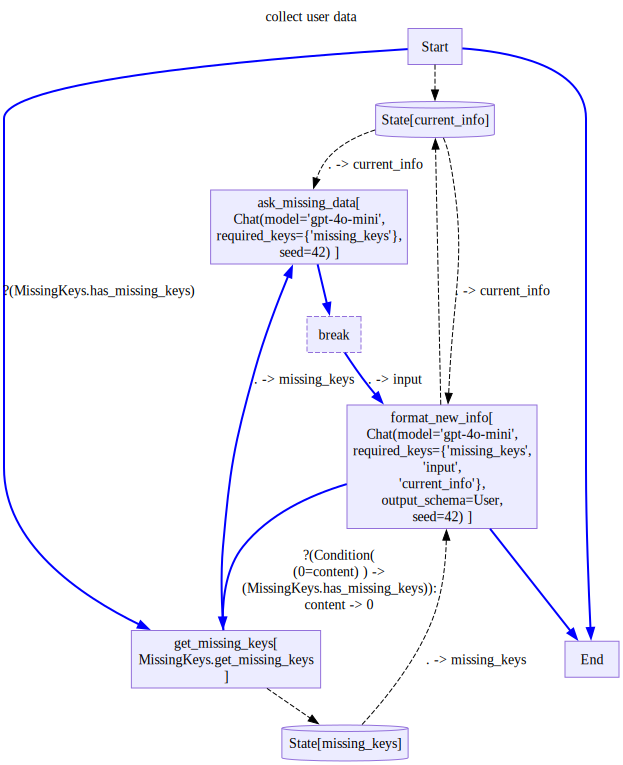

In [ ]:
with Define('collect user data',type='decision') as UserQA:
    V('Start',
        outputs=[
            ('get_missing_keys',missing.has_missing_keys),
            ('End',),
            ('state/current_info',)
        ])

    V('get_missing_keys',missing.get_missing_keys,
        outputs=[
            'ask_missing_data(missing_keys)',
            'state/missing_keys'

        ])

    V('ask_missing_data',ask_missing_data,
        inputs=['state/current_info(current_info)'],
        outputs=['break']    )

    V('break',is_break=True,outputs=['format_new_info(input)'])

    
    V('format_new_info',format_new_info,
        inputs=[
            'state/current_info(current_info)',
            'state/missing_keys(missing_keys=.)'
        ],
        outputs=[
            ('get_missing_keys(0=content)',Condition(missing.has_missing_keys,'(0=content)')),
            'End',
            'state/current_info'
        ])

UserQA.draw(direction='TB')


Now, let us create our custom state, which will have methods for getting and setting users in our db.

In [ ]:
class UserDBState(BaseModel):
    model_config = ConfigDict(extra='allow')
    engine: Optional[Any] = None
    user_id: Optional[int] = None
    # this is a private attribute that will not be serialized
    # used to cache the user object to avoid extra db calls
    _user:Optional[User]=None


    def get_user(self):
        user_id = self.user_id
        if not self._user is None:
            return self._user
        with Session(self.engine) as session:
            user = session.exec(select(User).where(User.id == user_id)).first()
            self._user = user
        if self._user is None:
            self._user = User(id=user_id)
        return self._user

    def add_user(self,user_data):
        self._user = user_data
        with Session(self.engine) as session:
            session.merge(user_data)
            session.commit()
        

Our new DB workflow will look very similar to the old one, but instead of reading and writing to current info, we will use the `get_user` and `add_user` methods of our state object.

We will also read the user info into start, so we can skip the workflow if we have all the info we need.

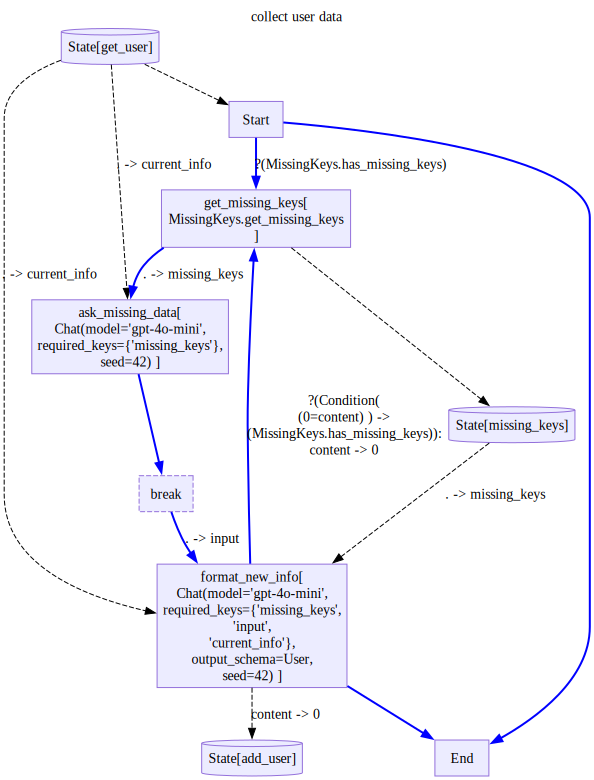

In [ ]:
with Define('collect user data',type='decision',state=UserDBState()) as UserQADB:
    V('Start',
        inputs=['state/get_user(0=.)'],
        outputs=[
            ('get_missing_keys',missing.has_missing_keys),
            ('End',),
        ])

    V('get_missing_keys',missing.get_missing_keys,
        outputs=[
            'ask_missing_data(missing_keys)',
            'state/missing_keys'

        ])

    V('ask_missing_data',ask_missing_data,
        inputs=['state/get_user(current_info)'],
        outputs=['break']    )

    V('break',is_break=True,outputs=['format_new_info(input)'])

    
    V('format_new_info',format_new_info,
        inputs=[
            'state/get_user(current_info)',
            'state/missing_keys(missing_keys=.)'
        ],
        outputs=[
            ('get_missing_keys(0=content)',Condition(missing.has_missing_keys,'(0=content)')),
            'End',
            'state/add_user(0=content)'
        ])

UserQADB.draw(direction='TB')


In [ ]:
d = UserQADB()
d.state.user_id = 1
d.state.engine = engine
d.state.get_user()

User(id=1, name=None, age=None, email=None)

In [ ]:
d.run_all(input=None)

{'role': 'assistant',
 'content': 'Could you please provide your name and age?',
 'meta': {'input_tokens': 50, 'output_tokens': 9}}

In [ ]:
d.run_all('alice, 25yo')

{'role': 'assistant',
 'content': User(id=1, name='alice', age=25, email=None),
 'meta': {'input_tokens': 356, 'output_tokens': 29}}

Since we have saved the result to a DB, if we try to run this diagram again for the same user, we will skip straight to the end, since all user data will be retrieved from the DB.

In [ ]:
d = UserQADB()
d.state.user_id = 1
d.state.engine = engine
d.state.get_user()

User(age=25, name='alice', id=1, email=None)

In [ ]:
d.run_all(input=None)

User(age=25, name='alice', id=1, email=None)